# Introduction to Image Classification with Transfer Learning

## What to take away from this presentation

- Python is a good choice for machine learning
- Jupyter Notebooks for easy experimentation
- Basic understanding of a Convolutional Neural Network (CNN)
- What transfer learning is
- Basic understanding of the requirements for training a CNN
- Familiarity with using the Keras framework and some other tools

## Main Tools

- Jupyter Notebooks: Browser-based python console that makes using Python easy
- Keras: A popular machine leaning framework and library for Python
- Tensorflow: A backend for Keras, as well as machine learning framework on its own.
 - Tensorflow is a library for high performance numerical computation.
- Tensorboard: Web Dashboard for visualizing tensorflow model training

## What is a CNN?

You can generally think of a CNN being used for image classification as having two major sections, responsible for feature extraction and classification.

The layers in a neural network that perform classification are usually referred to as the 'fully connected' layers, in our transfer learning example it is the weights or these layers that we'll be updating.

Initial layers in the CNN are for extracting features from the images to make the job of the fully connected layers easier (e.g. filtering, convolutions, pooling)

An in-depth explanation of neural net architectures is beyond the scope of this talk, though if you have any burning questions I can try and help you out. 

![CNN](https://cdn-images-1.medium.com/max/1200/1*XbuW8WuRrAY5pC4t-9DZAQ.jpeg)
https://medium.com/@RaghavPrabhu/understanding-of-convolutional-neural-network-cnn-deep-learning-99760835f148

When training a network what you are actually doing is minimising the loss function, this has to do with derivatives and simultaneous equations where you continuously make small changes to the network weights to improve the classification accuracy as you train.

## What is Transfer Learning?

Taking advantage of existing work done in the image classification field.

Specifically, building on the feature extraction layers of existing CNN architectures.

To do just that we can take a network that someone else has spent a long time training and just borrow the feature extraction bits of it, already pre-trained, typically these consist of convolution and pooling layers. We attach those borrowed layers onto some additional fully connected layers (the neural network) and train the complete model on our specific dataset.

# Getting into some code
We're just going to make all our Python imports up front to make code in later cells cleaner, imports are how you include external code in Python

In [1]:
# Keras Framework
import keras as K
# Numpy - matrix math library for Python written in C
import numpy as np
# Tensorflow Framework
import tensorflow as tf
# Matlab-like plotting library and
# enable interactive jupyter notebook plote of appropriate size
%matplotlib notebook
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 9.5, 6
import matplotlib.pyplot as plt
# scikit-learn, another machine learning framework that provides a lot of useful utilities
import sklearn
# General python standard library tools
import itertools
import time

Using TensorFlow backend.


## Obtain Dataset - CIFAR10

We'll be using the CIFAR10 dataset for the example, CIFAR10 is a dataset containing 50,000 32 by 32 RGB training images and 10,000 test images split into 10 categories.

Here's an example of some of those:

![cifar10](http://corochann.com/wp-content/uploads/2017/04/cifar10_plot_more.png)

Keras includes a copy of this dataset that's easily accessible entirely from code, so we can just import the data and begin using it (after waiting for it to download the first time we import it).

In [2]:
(input_train_orig, truth_train_orig), (input_test_orig, truth_test_orig) = K.datasets.cifar10.load_data()

In [6]:
truth_train_orig

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

CIFAR10 provides image truth as single number in the range 0-9, but we need a categorical representation, Keras provides us a function to generate this:

In [7]:
TRUTH_CLASSES = 10
truth_train = K.utils.to_categorical(truth_train_orig, TRUTH_CLASSES)
truth_test = K.utils.to_categorical(truth_test_orig, TRUTH_CLASSES)
print("Original Truth Format Example:   ", truth_train_orig[0])
print("Categorical Truth Format Example:", truth_train[0])

Original Truth Format Example:    [6]
Categorical Truth Format Example: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


Having loaded the dataset, we can plot a preview of some of the images to check what they look like, and what they're classified as.

<IPython.core.display.Javascript object>


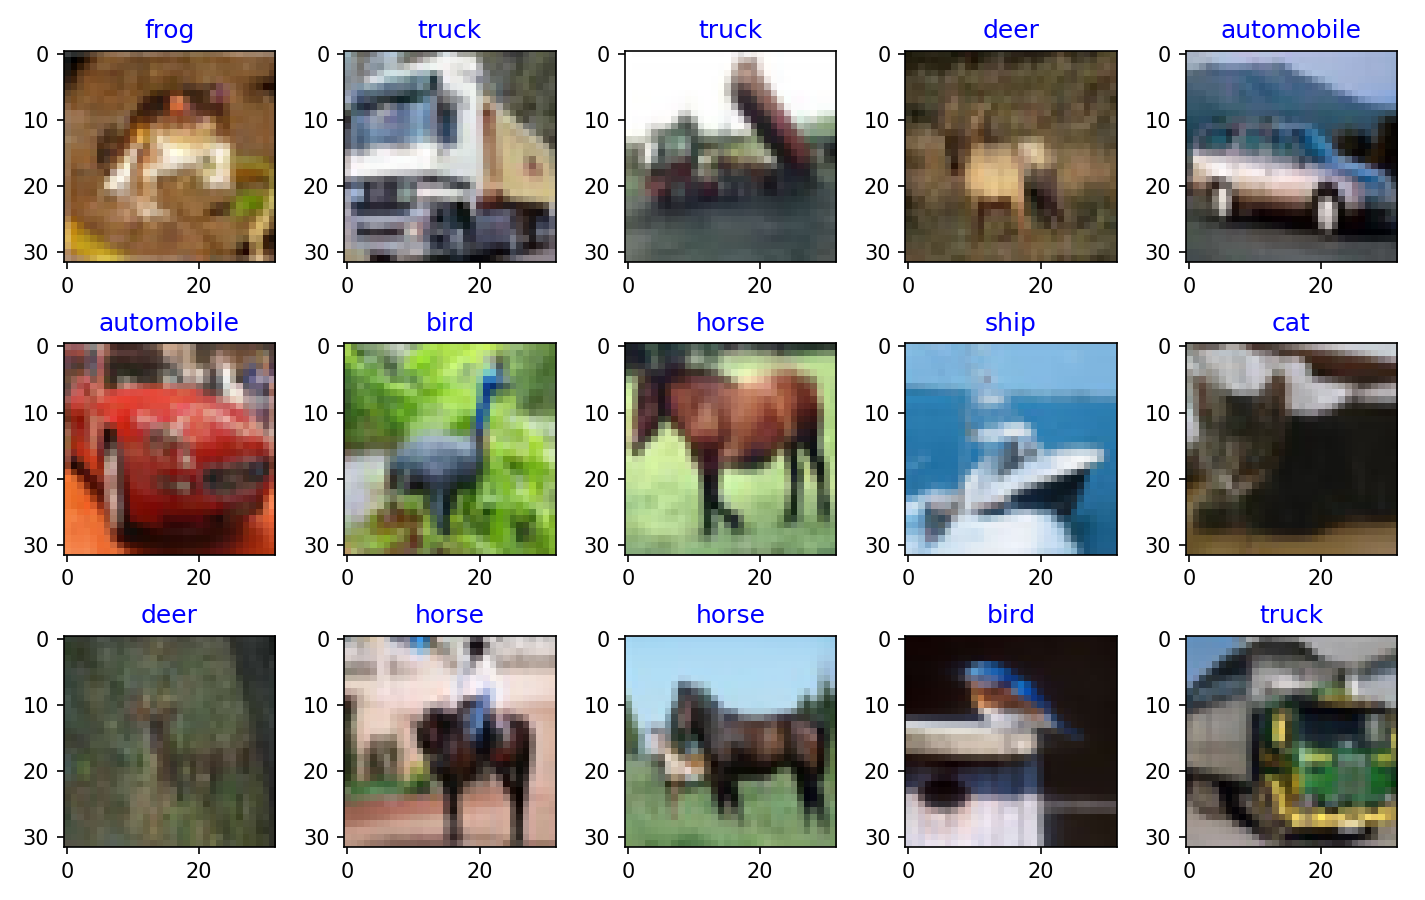

In [8]:
def plot_images(images, truths, rng, preds=None):
    """Plot some images labelled with their truth, and optionally the prediction the network made"""
    
    labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    cols = 5
    rows = len(rng) // cols
    plt.figure()
    
    truths = np.argmax(truths, axis=1)
    if preds is not None:
        preds = np.argmax(preds, axis=1)

    for i, idx in enumerate(rng):
        truth = labels[truths[idx]]
        plt.subplot(rows, cols, i+1)
        title = '{truth}'.format(truth=truth)
        color = 'b'
        if preds is not None:
            color = 'g'
            pred = labels[preds[idx]]
            join = '=='
            if pred != truth:
                color = 'r'
                join = '!='
            title = '"{pred}" {join} '.format(pred=pred, join=join) + title
            
        plt.title(title, color=color)
        plt.imshow(images[idx])
    plt.tight_layout()
        
plot_images(input_train_orig, truth_train, range(15))

# Import a pre-trained Model (VGG19)

To kick start our classification we'll base our model off the VGG19 CNN model, like getting a copy of CIFAR 10, Keras provides us an easy way to download this pre-trained model.

VGG has been pre-trained on another well-known dataset, ImageNet, so the convolutional layers will already be pretty good at extracting features from the images. 

Note the `include_top` argument when importing the model is false - this is a convenience feature for transfer learning when importing models in Keras, it means that the importd model doe not include fully-connected layers, so that we can define our own and attach them easily.

In [10]:
# The minimum image size that our pre-trained imported VGG19 supports is 48x48
# We will have to upscale our training images before we can train the network
INPUT_DIM = 48;

vgg19 = K.applications.vgg19.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(INPUT_DIM, INPUT_DIM, 3),
)

# The imported layers are already trained in ImageNet,
# So we can mark them as not trainable to prevent weights modification
for layer in vgg19.layers:
    layer.trainable = False

Keras provides a method for us to summarise a model as text, we can inspect what we've downloaded:

In [11]:
vgg19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

# Image Preprocessing

If we scroll up and look at the input layer of our model - note the expected input size of 48x48x3 (the 3 is for the RGB channels), but remember the CIFAR10 images are 32x32:

In [12]:
print('Train Input Shape, 50000 items):', input_train_orig.shape)
print('Test Input Shape, 10000 items): ', input_test_orig.shape)

Train Input Shape, 50000 items): (50000, 32, 32, 3)
Test Input Shape, 10000 items):  (10000, 32, 32, 3)


What to do? Well we can just resize all the images in our input dataset, tensorflow provides a handy helper function for just this

In [13]:
%%time
input_train_big_tensor = tf.image.resize_images(input_train_orig, [INPUT_DIM, INPUT_DIM])
input_test_big_tensor  = tf.image.resize_images(input_test_orig, [INPUT_DIM, INPUT_DIM])

with K.backend.get_session().as_default():
    input_train_big = input_train_big_tensor.eval().astype('uint8')
    input_test_big  = input_test_big_tensor.eval().astype('uint8')

CPU times: user 7.42 s, sys: 3.04 s, total: 10.5 s
Wall time: 10.5 s


Now we run the resized images through a preprocessing function provided by VGG19 - this just converts the channels to BGR instead of RGB, then subtracts the average BGR values for the `ImageNet` dataset from each pixel in our input images.

In [14]:
%%time
input_train_preprocessed = K.applications.vgg19.preprocess_input(input_train_big)
input_test_preprocessed = K.applications.vgg19.preprocess_input(input_test_big)

CPU times: user 740 ms, sys: 376 ms, total: 1.12 s
Wall time: 1.12 s


## Visualise the Preprocessing

Let's check that the resized images look somewhat similar to the original images:

Take a note though, that the preprocessing function has made some of the RGB channels negative (and made the data type `float32`), here I've cast the data type to `uint8` to make visualisation effective, but it means that some channels overflow.

<IPython.core.display.Javascript object>


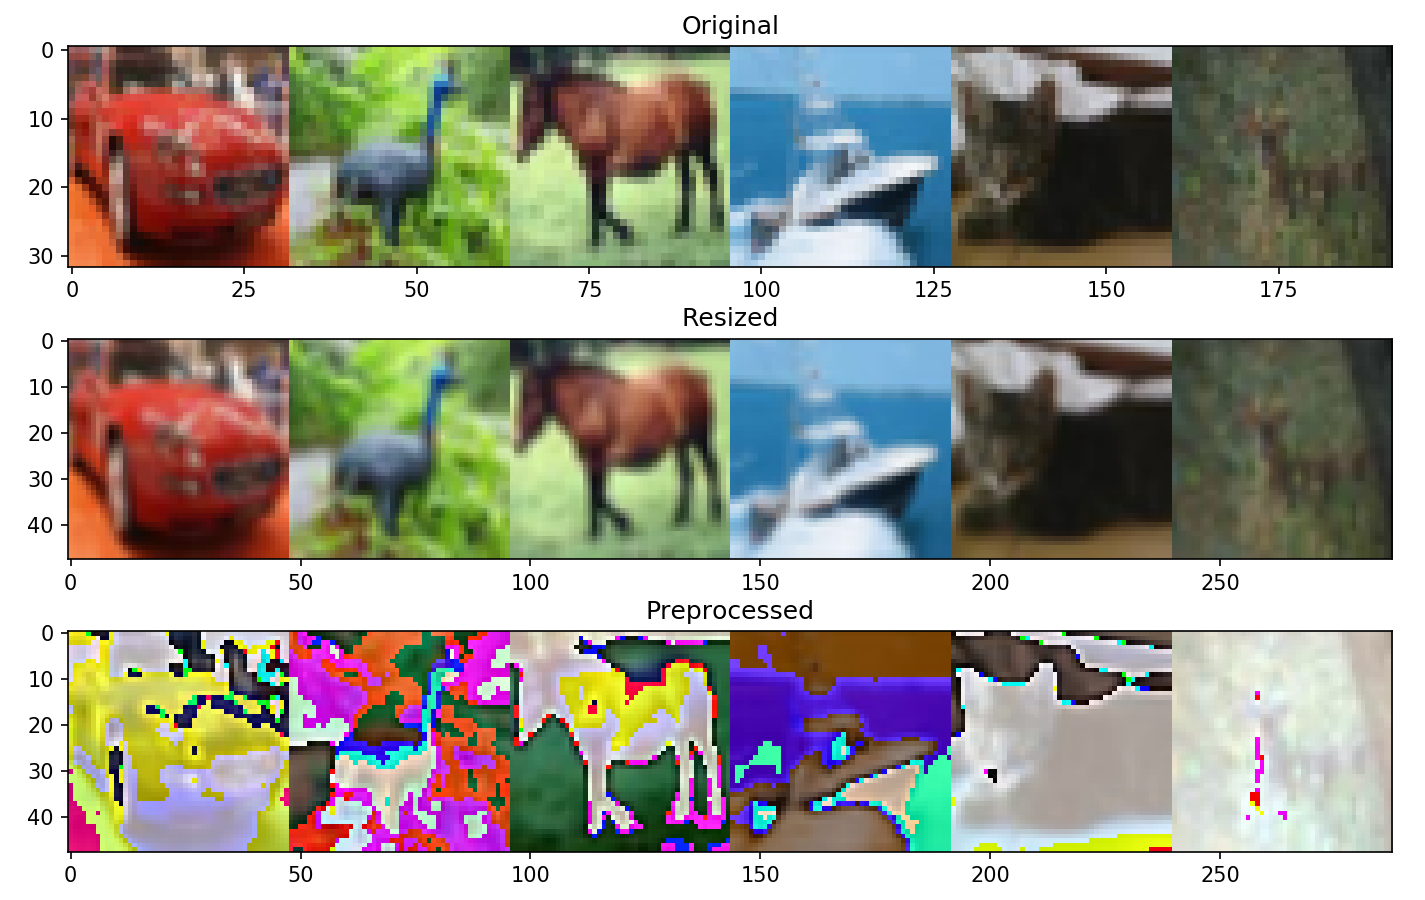

In [17]:
start = 5
num = 6

plt.figure()

plt.subplot(311)
plt.title('Original')
plt.imshow(np.concatenate(input_train_orig[start:start+num], axis=1))

plt.subplot(312)
plt.title('Resized')
plt.imshow(np.concatenate(input_train_big[start:start+num], axis=1))

plt.subplot(313)
plt.title('Preprocessed')
plt.imshow(np.concatenate(input_train_preprocessed[start:start+num].astype('uint8'), axis=1))

plt.tight_layout()

Just to check we understand what happened, we can look at the transformation of the top left pixel of each image.

In [18]:
print('Original')
print(' Type:', input_train_orig.dtype)
print(' Values:', input_train_orig[0,0,0])
print('\nResized')
print(' Type:', input_train_big.dtype)
print(' Values:', input_train_big[0,0,0])
print('\nPreprocessed (Convert tp BGR and subtract Imagenet Means)')
print(' Type:', input_train_preprocessed.dtype)
print(' Values:', input_train_preprocessed[0,0,0])


IMAGENET_BGR_MEANS = [103.939, 116.779, 123.68]
print('\nManually Processed (Flipped and ImageNet means subtracted)')
print(' Values:', np.flip(input_train_big[0,0,0], axis=0) - IMAGENET_BGR_MEANS)

Original
 Type: uint8
 Values: [59 62 63]

Resized
 Type: uint8
 Values: [59 62 63]

Preprocessed (Convert tp BGR and subtract Imagenet Means)
 Type: float32
 Values: [-40.939003 -54.779    -64.68    ]

Manually Processed (Flipped and ImageNet means subtracted)
 Values: [-40.939 -54.779 -64.68 ]


# Attach and Train our own Layers

Now we create our own fresh layers, attach them to the VGG19 model we imported, and train the resulting franken-model, which we can then run our testing dataset on and see how it performs!

We're first going to flatten the output of the VGG model so we have a single dimensional tensor of the last layer in the VGG model, then attach that to three fully connected layers with 512, 512, and 128 neurons respectively. Finally we will have a fully connected layer with 10 neurons (one for each class) as the output layer.

When the network produces an output for a single input, it will have 10 values between 0 and 1, and the index of the highest output is the prediction of the network.

In [23]:
# Create a sequence of fully-connected layers that build on the imported vgg19 network
# To do this we use the keras functional API
x = K.layers.Flatten()(vgg19.output)
x = K.layers.Dense(261, activation='relu')(x)
output = K.layers.Dense(TRUTH_CLASSES, activation='softmax')(x)

# Wrap the layer sequence in a Keras Model, required for running the training
model = K.models.Model(vgg19.input, output)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

Now we've put together the model we need to decide some of the parameters that will be used for training, and compile the model, which configures the tensorflow models for training.

When we compile this model we give it:
- `optimiser`: The optimiser controls the learning rate of the model, updates to the weights.
- `loss`: The type of function used to generate an measure of how well the model is performing on the data, the closet the loss measurement gets to 0, the better the model performed on a given dataset
- `metrics`: Functions used to judge the model performance, while this is similar to the loss function, they serve  different purposes and it's easier for a human to understand accuracy

In [24]:
optimizer = 'sgd'
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Set up Tensorboard for training visualisation

This is an optional step, but pretty useful for seeing how things are going. Run the following in the directrory of the notebook to start tensorboard (it will have been installed when we installed tensorflow)

```
tensorboard --logdir graph
```

We then define a callback that will write training logs to the same directory we have as the `--logdir` argument to tensorboard

In [25]:
def get_tb_callback(optimizer, batch, epochs):
    train_name = "{time} optimizer={op} batch={batch} epochs={epochs}".format(
        time=time.strftime("%Y-%m-%d %H%M"),
        batch=batch,
        op=optimizer,
        epochs=epochs)
    return K.callbacks.TensorBoard(log_dir='./graph/' + train_name, write_graph=False)

Finally we get to actually train the network (Keras calls this 'fitting'). 

The key things here are:
- `epochs`: One full presentation of all entries the training dataset to the network
- `batch`: How many entries to present to the network before performing a gradient update (changing weights, which is how the network really learns)
- `validation_split`: Portion of the training data set aside and not used for training, but instead used for validation (checking if we've overtrained the network)

In [26]:
batch=32
epochs=2
tensorboard_callback = get_tb_callback(optimizer, batch, epochs)
h = model.fit(
    input_train_preprocessed,
    truth_train,
    epochs=epochs,
    batch_size=batch,
    shuffle=True,
    verbose=1,
    validation_split=0.2,
    callbacks=[tensorboard_callback]
)

Train on 40000 samples, validate on 10000 samples
Epoch 1/2
40000/40000 [==============================] - 12s 303us/step - loss: 1.6642 - acc: 0.5816 - val_loss: 1.0952 - val_acc: 0.6253
Epoch 2/2
40000/40000 [==============================] - 12s 298us/step - loss: 0.9207 - acc: 0.6828 - val_loss: 1.0301 - val_acc: 0.6533


All the model building and training code wrapped up neatly so we can tweak parameters easily:

In [ ]:
def train_isolated():
    neurons = 261
    batch = 32
    epochs = 10
    
    vgg19 = K.applications.vgg19.VGG19(
        include_top=False,
        weights='imagenet',
        input_shape=(INPUT_DIM, INPUT_DIM, 3),
    )
    for layer in vgg19.layers:
        layer.trainable = False
    x = K.layers.Flatten()(vgg19.output)
    x = K.layers.Dense(neurons, activation='relu')(x)
    output = K.layers.Dense(TRUTH_CLASSES, activation='softmax')(x)
    model = K.models.Model(vgg19.input, output)
    optimizer = 'sgd'
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    tensorboard_callback = get_tb_callback(optimizer, batch, epochs)
    h = model.fit(
        input_train_preprocessed,
        truth_train,
        epochs=epochs,
        batch_size=batch,
        shuffle=True,
        verbose=1,
        validation_split=0.2,
        callbacks=[tensorboard_callback]
    )
    return model
    
train_isolated()

## Evaluate Performance

It's important to check the accuracy of the model on data that wasn't part of the training process, to validate that the model has not been overtrained on the training data. This is what we use the testing set of CIFAR 10 for.

In [27]:
test_loss, test_acc = model.evaluate(input_test_preprocessed, truth_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc * 100, '%')

10000/10000 [==============================] - 2s 213us/step
Test loss: 1.0432876794815062
Test accuracy: 65.51 %


Confusion matricies are an excellent way to provide visibility into any classes the model is performing poorly on

In [28]:
from sklearn.metrics import confusion_matrix
test_pred = model.predict(input_test_preprocessed, verbose=1, batch_size=256)
test_pred_final = np.argmax(test_pred, axis=1)
test_confusion = sklearn.metrics.confusion_matrix(truth_test_orig, test_pred_final)

10000/10000 [==============================] - 2s 169us/step


In [29]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[0.698 0.024 0.046 0.013 0.018 0.008 0.008 0.024 0.126 0.035]
 [0.024 0.718 0.007 0.024 0.009 0.01  0.006 0.008 0.061 0.133]
 [0.063 0.011 0.595 0.059 0.103 0.044 0.079 0.022 0.021 0.003]
 [0.015 0.03  0.066 0.445 0.06  0.187 0.086 0.044 0.027 0.04 ]
 [0.03  0.007 0.092 0.036 0.577 0.045 0.079 0.099 0.028 0.007]
 [0.011 0.021 0.055 0.134 0.048 0.633 0.042 0.034 0.014 0.008]
 [0.015 0.009 0.073 0.048 0.087 0.033 0.722 0.004 0.008 0.001]
 [0.026 0.009 0.04  0.056 0.081 0.087 0.006 0.656 0.019 0.02 ]
 [0.092 0.051 0.007 0.018 0.013 0.003 0.006 0.01  0.764 0.036]
 [0.029 0.099 0.007 0.012 0.004 0.008 0.002 0.015 0.081 0.743]]


<IPython.core.display.Javascript object>


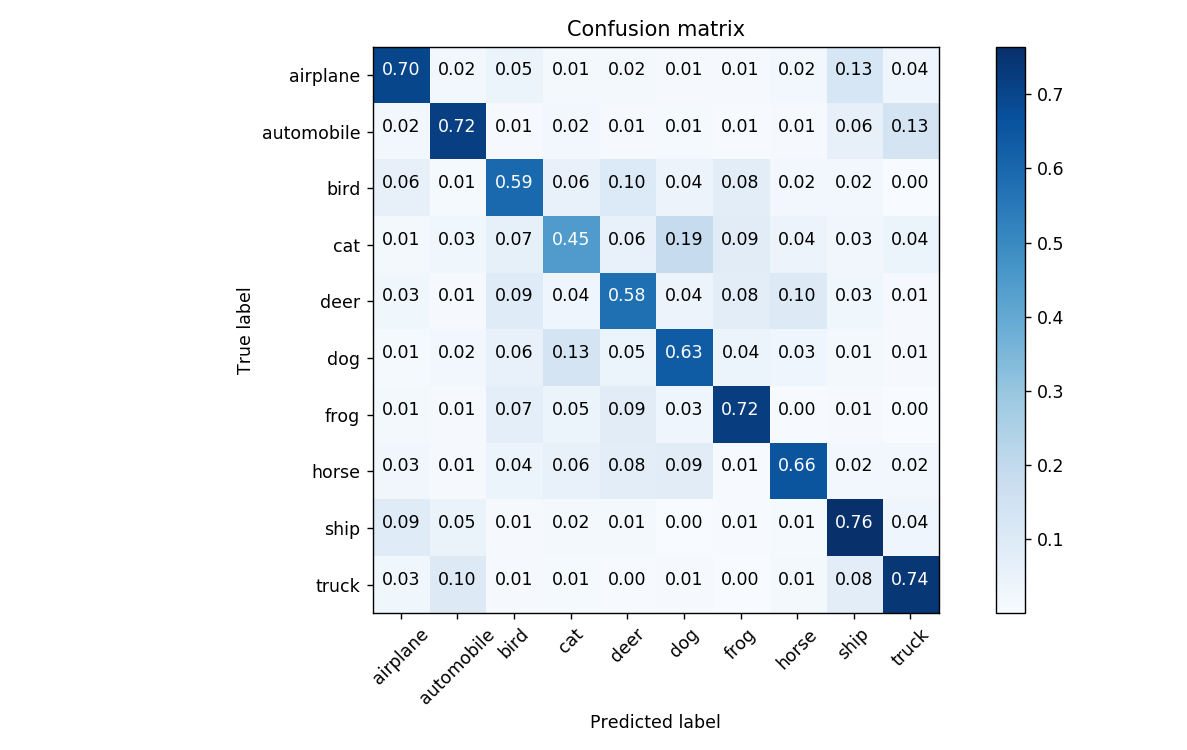

In [30]:
plot_confusion_matrix(test_confusion, ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], normalize=True)

# Make Some Predictions!

Creating predictions on the testing dataset and storing them:

In [31]:
predictions = model.predict(input_test_preprocessed, verbose=1, batch_size=256)

10000/10000 [==============================] - 1s 119us/step


Plot a sample of those predictions using the function we created for that purpose earlier:

<IPython.core.display.Javascript object>


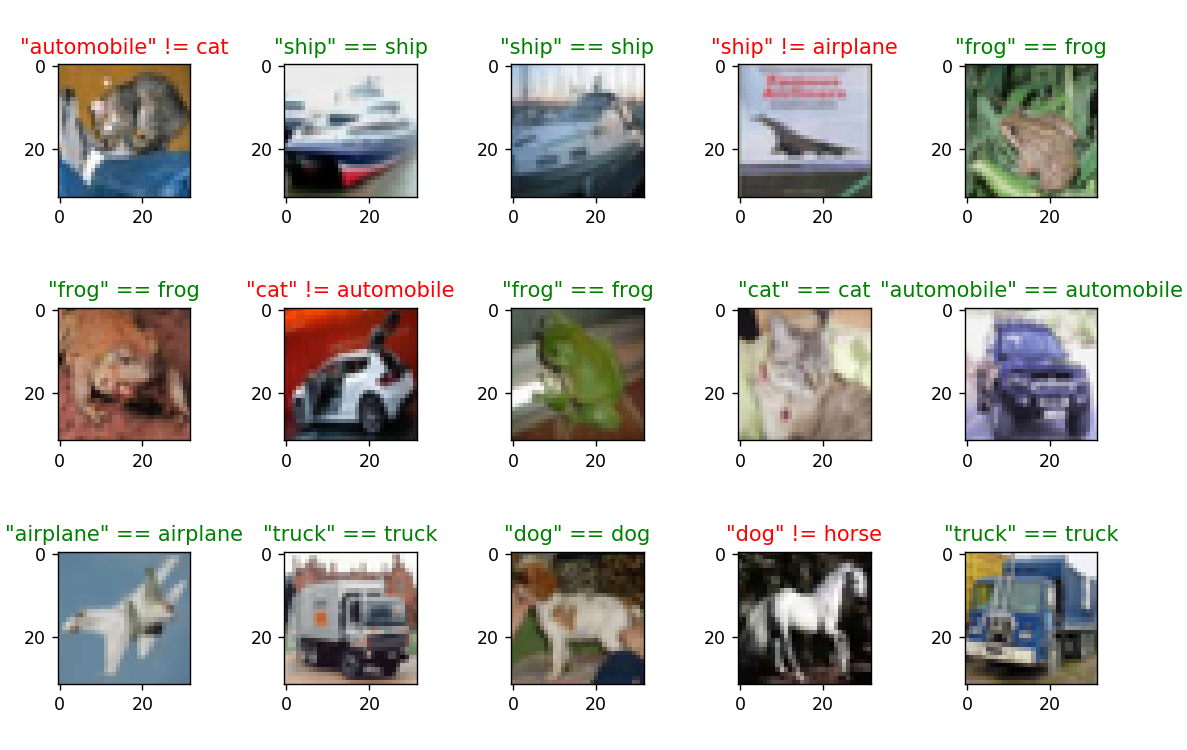

In [32]:
plot_images(input_test_orig, truth_test, range(15), preds=predictions)

# Next Steps - tweak the training

Now it becomes a game of experiments, we can do lots of things to improve the model performance, e.g:
- Reducing the learning rate, and training for more epochs, to reduce the risk of overtraining
- Implement layers that are designed to mitigate overtraining so we can train for longer (e.g. Dropout layers)
- Perform data augmentation to generate more, slightly different data (things like flippign and sliding images)

# Train More Models!

We can train another model with different parameters and see how the training progress differs in tensorboard, say we want to experiment with how batch size affects training...

In [ ]:
batches = [30, 30, 30, 32, 32, 32, 34, 34, 34]
optimizers = ['sgd']


for op in optimizers:
    for bat in batches:
        print('Optimizer:', op, 'Batch:', bat)
        # create another model
        x = K.layers.Flatten()(vgg19.output)
        x = K.layers.Dense(261, activation='relu')(x)
        output = K.layers.Dense(TRUTH_CLASSES, activation='softmax')(x)
        newmodel  = K.models.Model(vgg19.input, output)
        
        newmodel.compile(optimizer=op, loss='categorical_crossentropy', metrics=['accuracy'])
        epochs = 10
        newmodel.fit(
            input_train_preprocessed,
            truth_train,
            epochs=epochs,
            batch_size=bat,
            shuffle=True,
            verbose=2,
            validation_split=0.2,
            callbacks=[get_tb_callback(op, bat, epochs)]
        )
        
        test_loss, test_acc = newmodel.evaluate(input_test_preprocessed, truth_test)
        print('Test loss:', test_loss)
        print('Test accuracy:', test_acc * 100, '%')
        print('----------------------------------')